# IMA 208 TP5: homography estimation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In this practical work, we will study how to estimate an homography between two given images. We will consider both the simple DLT algorithm (part I) and the RANSAC algorithm (part II).

To reduce the time you need for this practical work, we will use a few pre-implemented functions of openCV. Make sure that your library installation is correct before starting to work.

# Part 1: homography estimation from hand-selected keypoints: DLT algorithm

We assume that we have an image of a documents suffering from severe perspective distortion. The objective of this part is to warp this image (denoted in the following as img2) to remove the distortion using a reference image beeing in the desired pose (denoted as img1).

The following cell enables to vizualize the images using openCV.

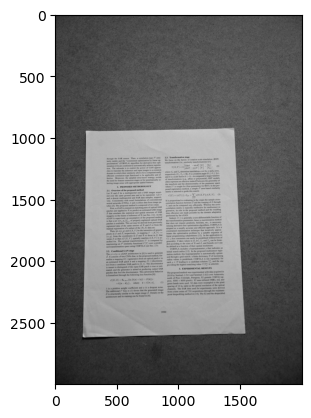

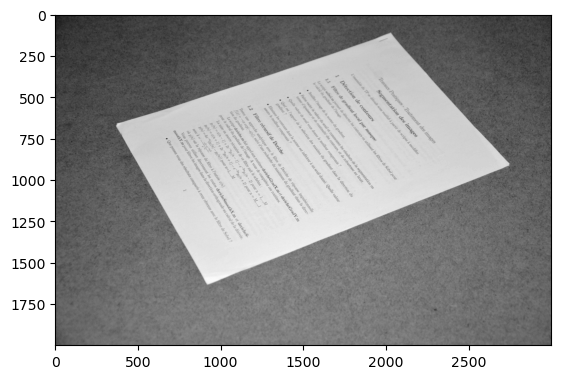

In [2]:
# Reference image
img1 = cv2.cvtColor(cv2.imread("Feuille_redressee.jpg"), cv2.COLOR_BGR2GRAY)

# Image to be processed
img2 = cv2.cvtColor(cv2.imread("Feuille.jpg"), cv2.COLOR_BGR2GRAY)

plt.figure(), plt.imshow(img1, cmap="gray")
plt.figure(), plt.imshow(img2, cmap="gray")
plt.show()

To correct the homography beetween the to images, we will need some points to match between the two images.

**Question:** how many points do you at least need to estimate the homography? Why?

**Answer:**

To estimate a homography between two images, one needs at least four corresponding points. This is because a homography is a transformation matrix that maps points from one image to another in a projective manner. 

With four points, one can set up a system of linear equations to solve for the elements of the homography matrix. Each point correspondence provides two linear equations, resulting in a total of eight equations. However, since the homography matrix has eight degrees of freedom (since it's a 3x3 matrix with nine elements but is constrained by the fact that it's a homography), one needs at least four point correspondences to solve the system of equations uniquely.

Having more than four points can improve the robustness of the estimation by allowing for better outlier rejection and improving the accuracy of the estimated homography.

**Implementation:** to estimate the homography, some matching keypoints between the reference image and the to-be-porcessed one are given below. They here correspond to the corners of the two documents.

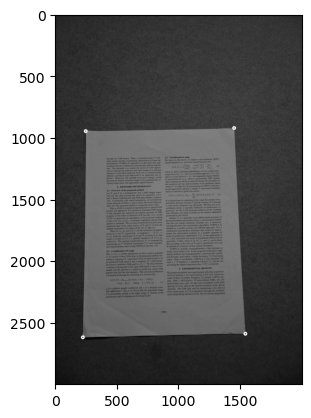

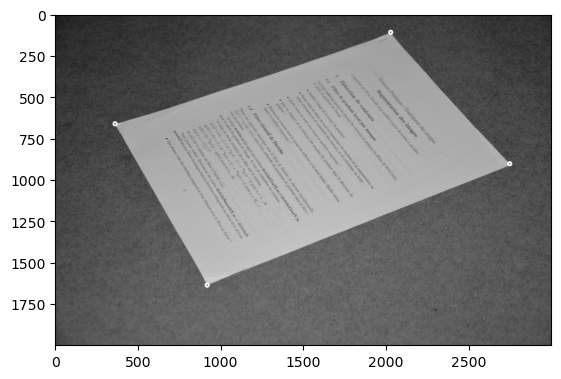

In [3]:
# Keypoints for img1. Should be a list in format [[first_point_row,first_point_column],[second_point_row,second_point_column],...]
pts1 = [
    [248, 949],
    [1450, 924],
    [1541, 2592],
    [225, 2621],
]

# Keypoints for img2,  keep the same order of the points as pts1.
pts2 = [
    [2030, 110],
    [2750, 904],
    [920, 1638],
    [363, 663],
]

# Below, we convert the points you found above into cv2 points object for vizualization (no need to change anything)
kp1 = [cv2.KeyPoint(pt[0], pt[1], 1) for pt in pts1]
kp2 = [cv2.KeyPoint(pt[0], pt[1], 1) for pt in pts2]

img1_plot = img1.copy()
for i in range(len(pts1)):
    img1c = cv2.circle(img1_plot, pts1[i], radius=10, color=(255, 0, 0), thickness=10)
plt.figure(), plt.imshow(img1c, cmap="gray")

img2_plot = img2.copy()
for i in range(len(pts2)):
    img2c = cv2.circle(img2_plot, pts2[i], radius=10, color=(255, 0, 0), thickness=10)
plt.figure(), plt.imshow(img2c, cmap="gray")


# In all the following, we will use the convention that np.shape(pts1) = [2,number_of_points]
pts1 = np.array(pts1).T

# In all the following, we will use the convention that np.shape(pts1) = [2,number_of_points]
pts2 = np.array(pts2).T

**Visualize** the keypoints you found above to check that they are properly assigned.

Now, we will start implementing the DLT.

**Question:** recall what the DLT is. Give a pseudo code. What are its potential flaws and strengths?

**Answer:**

DLT (Direct Linear Transformation) is a method used to compute the homography (or perspective transformation) between two images given a set of corresponding points. The DLT algorithm works by solving a system of linear equations derived from the point correspondences.

Here's a pseudo code for the DLT algorithm (one could initially normalize the data):

   1. Input:
      - Source points: $(x_1, y_1), \dots, (x_n, y_n)$
      - Destination points: $(x'_1, y'_1), \dots, (x'_n, y'_n)$

   2. Formulate the system of linear equations: construct the matrix $A$, where each two rows corresponds to a point correspondence:

      $$
      A = 
      \begin{bmatrix}
      0   & 0   & 0  & -x_i & -y_i & -1 & x_i\cdot y'_i & y_i\cdot y'_i & y'_i \\
      x_i & y_i & 1 & 0   & 0   & 0  & -x_i\cdot x'_i & -y_i\cdot x'_i & x'_i \\
      \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots
      \end{bmatrix}
      $$

   3. Obtain the SVD of $A$: for $A=UDV^T$, with $D$ diagonal with positive diagonal entries arranged in descending order down the diagonal, then the solution $h$ is the last column of $V$.

   4. Reshape the solution to obtain the homography matrix: reshape the vector $h$ into a $3\times 3$ matrix $H$, representing the homography between the two images.

   5. Output:
      - Homography matrix H

Potential flaws of the DLT algorithm include:

   1. Sensitivity to outliers: The DLT algorithm is sensitive to outliers in the point correspondences, which can lead to inaccurate estimates of the homography.

   2. Degenerate cases: If the point correspondences are co-linear or nearly co-linear, the matrix A can become singular, leading to an inability to solve for the homography matrix H.

   3. Lack of robustness: The DLT algorithm does not inherently handle noise or errors in the point correspondences, which can result in inaccurate homography estimates.

Strengths of the DLT algorithm include:

   1. Simplicity: The DLT algorithm is relatively simple to implement and understand, making it accessible for various applications.

   2. Flexibility: The DLT algorithm can be applied to estimate the homography between images captured from different perspectives or viewpoints, enabling tasks such as image stitching, object tracking, and augmented reality.

The first step of the DLT algorithm is to normalize the image point.

**Question:** Recall why the normalization is important. Recall how to do it.

**Answer:**

Normalization of image points is important in the context of the DLT algorithm because it helps to improve the numerical stability and accuracy of the computations involved. Normalization involves scaling and translating the image points so that they have certain properties, such as having a centroid at the origin and an average distance from the origin equal to sqrt(2).

Here's why normalization is important:

   1. Numerical stability: Normalization helps to ensure that the values used in subsequent calculations are within a reasonable range, which can prevent numerical instabilities such as overflow or underflow.

   2. Robustness to scale: By normalizing the scale of the points, the algorithm becomes more robust to changes in scale between images, which can occur due to variations in camera parameters or distances between objects and the camera.

   3. Robustness to translation: Normalizing the centroid of the points to be at the origin makes the algorithm more robust to translations in the image, ensuring that the transformation is invariant to translations.

The normalization process typically involves the following steps:

1. Compute centroid: Compute the centroid (average) of all the image points by averaging their x and y coordinates:

   $$
   \bar{x} = \frac{1}{n}\sum_{i=1}^{n}x_i \quad \text{and} \quad \bar{y} = \frac{1}{n}\sum_{i=1}^{n}y_i
   $$

2. Translate points: Translate the image points so that the centroid is at the origin:

   $$
   x'_i = x_i - \bar{x} \quad \text{and} \quad y'_i = y_i - \bar{y}
   $$

3. Compute average distance: Compute the average distance from the origin for all the translated points:

   $$
   \text{avg\_dist} = \frac{1}{n}\sum_{i=1}^{n}\sqrt{x'^2_i + y'^2_i}
   $$

4. Scale points: Scale the translated points so that the average distance from the origin is equal to $\sqrt{2}$:

   $$
   s = \frac{\sqrt{2}}{\text{avg\_dist}}
   $$

   $$
   x''_i = s \times x'_i \quad \text{and} \quad y''_i = s \times y'_i
   $$

After normalization, the transformed points $(x''_i, y''_i)$ can then be used in subsequent computations such as constructing the matrix $A$ in the DLT algorithm.

In the following, we will perform the normalization using the so called *homogeneous* coordinates of the keypoints. The main idea is to add a last coordinate equal to one for each point. The point (x,y) thus becomes (x,y,1) in homogeneous coordinate.

The advantage is that we will be able to do the normalization using a simple matrix product : X_norm = T@X.

**Fill** the blanks in the below implementation.

In [4]:
def normalize_image_points(imageEucl):
    """
    Input: 2D list with x,y image points
    Output: normalized data points
    """

    print("Normalizing data using similarity matrix...")

    # To be filled, (elementwise) mean and std of the data points
    mean, std = np.mean(imageEucl, axis=1), np.std(imageEucl)

    # Image in homogeneous coordinate
    image = np.vstack((imageEucl, np.ones(imageEucl.shape[1])))

    # Define a similarity matrix enabling to normalize the data.
    # Write the cooefficients in Tranformation such that image_norm = image@Transformation
    Transformation = np.array(
        [
            [std / np.sqrt(2), 0, mean[0]],
            [0, std / np.sqrt(2), mean[1]],
            [0, 0, 1],
        ]
    )
    Transformation = np.linalg.inv(Transformation)

    # Apply transformation on data points
    image_norm = Transformation @ image

    # Retrieve normalized image in the original input shape (25, 2)
    image_norm = image_norm[0:2, :]

    return image_norm, Transformation

**Question:** Verify that your data looks properly normalized.

In [5]:
normalize_image_points(np.array(pts1))

Normalizing data using similarity matrix...


(array([[-1.00759739,  0.95216323,  1.10053113, -1.04509697],
        [-1.34101756, -1.38177798,  1.33775673,  1.38503881]]),
 array([[ 1.63041649e-03,  0.00000000e+00, -1.41194068e+00],
        [ 0.00000000e+00,  1.63041649e-03, -2.88828281e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]))

The second step is to compute the A matrix from the normalized data points.

**Fill** the blanks in the function below.

**Question:** justify the shape of the A matrix.

**Answer:**

The shape of the $A$ matrix in the context of the DLT algorithm is determined by the number of correspondences used for estimating the homography. Since each correspondence provides two equations (one for the x-coordinate and one for the y-coordinate), and the homography matrix has $8$ degrees of freedom (since it's a $3\times 3$ matrix but is constrained by the fact that it's a homography), the $A$ matrix needs to be constructed as a $2n \times 9$ matrix, where $n$ is the number of correspondences.

In [6]:
def compute_matrix_A(points1, points2, no_points):
    """
    Input: Already normalized correspondences for image1 and image2
    Output: Matrix A as defined in Zisserman p. 91
    """

    A = []

    for i in range(0, no_points):
        x, y = (
            points1[0, i],
            points1[1, i],
        )  # Denote the coordinate in image 1 x and y for shortcut
        x_prime, y_prime = (
            points2[0, i],
            points2[1, i],
        )  # Denote the coordinate in image 2 x_prime and y_prime for shortcut

        # Create A_i according to the fomula given in class
        # here we are assuming w_i and w_i_prime are one
        A.append([0, 0, 0, -x, -y, -1, x*y_prime, y*y_prime, y_prime])
        A.append([x, y, 1, 0, 0, 0, -x*x_prime, -y*x_prime, -x_prime])

    print("\nStacked matrix A shape:", np.shape(A))

    return np.asarray(A)

We are now ready to code the whole homography computation function. 

**Fill** the gaps below.

In [7]:
def compute_homography(pts1, pts2):
    # Set data points to numpy arrays
    no_points = pts1.shape[1]  # Number of points

    # Normalize the data
    image1_normalized, T = normalize_image_points(pts1)
    image2_normalized, T_prime = normalize_image_points(pts2)

    # Get matrix A
    # A = ...
    A = compute_matrix_A(image1_normalized, image2_normalized, no_points)

    # Compute SVD of A
    U, S, V = np.linalg.svd(A)
    V = V.T  # So that A = USV.T

    # Get last column of V (this is the vector h)
    h = V[:, -1]

    # Obtain homography by reshaping h (H tilde)
    print("\nReshaping to get homography H_tilde...")
    H_tilde = h.reshape(3, 3)

    # Denormalize to obtain homography (H) using the transformations and generalized pseudo-inverse
    H = np.linalg.pinv(T_prime) @ H_tilde @ T

    print("\nDenormalized to obtain homography H for 2D data points...")
    print("Matrix H:")
    print(H)

    return H

**Question:** Apply the compute_homography function to warp the document image 2 into the perspective of document 1. Any comment ?

Normalizing data using similarity matrix...
Normalizing data using similarity matrix...

Stacked matrix A shape: (8, 9)

Reshaping to get homography H_tilde...

Denormalized to obtain homography H for 2D data points...
Matrix H:
[[ 1.85076958e-01 -6.02783511e-01  1.75577622e+03]
 [ 3.50026235e-01  2.02580262e-01 -2.12424774e+02]
 [-6.01779177e-05 -4.71184896e-06  6.25126583e-01]]


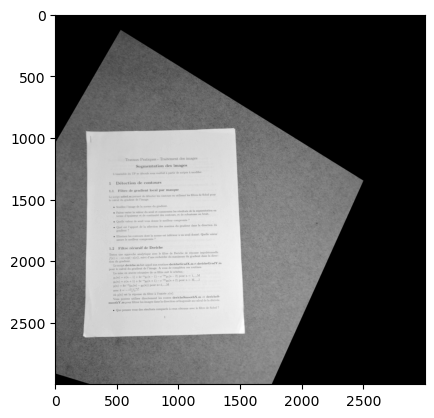

In [8]:
H = compute_homography(pts1, pts2)
homography_matrix_normalized = H
result = cv2.warpPerspective(
    img2, np.linalg.inv(homography_matrix_normalized), (3000, 3000)
)
plt.imshow(result, cmap="gray")
plt.show()

**Answer:**

The algorithm works as expected, as the homography was successfully estimated, which can be seen by `img2` being warped to the perspective of `img1`.

**Question:** test the sensitivity of the above algorithm to errors in the matching keypoints. Are you able to obtain good results if you have a false match?

Answer to the same question is you have more matching points than the corners.

**Answer:**

In real-world scenarios, the impact of false matches on homography estimation can be profound and is influenced by several factors. These include the quality and quantity of the keypoints, the complexity of the scene being captured, and the robustness of the homography estimation algorithm. Even a small number of false matches can significantly undermine the accuracy of the estimated homography, leading to misalignment or distortion in the transformed images.

In the tested example, we are working with the bare minimum of keypoints (four), which is necessary for estimating a homography. With such a limited number of keypoints, the false match of even a single keypoint can severely compromise the accuracy of the homography. This sensitivity to errors in matching keypoints is a characteristic of the DLT.

On the other hand, the addition of more matching keypoints helps improving the robustness of the homography estimation algorithm against false matches. Increasing the number of keypoints provides more redundant information, which allows the algorithm to better estimate the homography. As a result, the impact of false matches on the estimated homography is mitigated, leading to more accurate transformations.

Normalizing data using similarity matrix...
Normalizing data using similarity matrix...

Stacked matrix A shape: (8, 9)

Reshaping to get homography H_tilde...

Denormalized to obtain homography H for 2D data points...
Matrix H:
[[-9.79413439e-02 -6.02403654e-01  1.86288739e+03]
 [ 2.66463720e-01  2.48754015e-01 -2.33499895e+02]
 [-1.65833242e-04  5.60501661e-05  6.12032015e-01]]


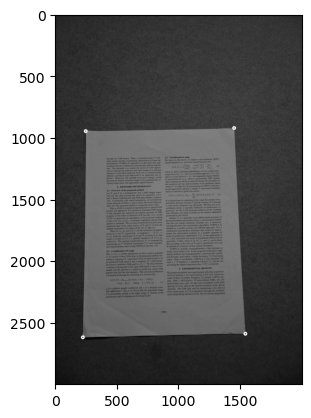

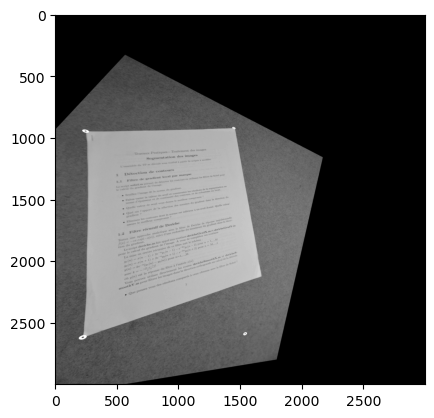

In [9]:
pts1 = [
    [248, 949],
    [1450, 924],
    [1541, 2592],
    [225, 2621],
]

pts2 = [
    [2030, 110],
    [2750, 904],
    [300, 1638], # altered keypoint: original [920, 1638]
    [363, 663],
]

img1_plot = img1.copy()
for i in range(len(pts1)):
    img1c_dec = cv2.circle(img1_plot, pts1[i], radius=10, color=(255, 0, 0), thickness=10)
plt.figure(), plt.imshow(img1c_dec, cmap="gray")

img2_plot = img2.copy()
for i in range(len(pts2)):
    img2c_dec = cv2.circle(img2_plot, pts2[i], radius=10, color=(255, 0, 0), thickness=10)
plt.figure(), plt.imshow(img2c_dec, cmap="gray")

# In all the following, we will use the convention that np.shape(pts1) = [2xnumber_of_points]
pts1 = np.array(pts1).T
# In all the following, we will use the convention that np.shape(pts1) = [2xnumber_of_points]
pts2 = np.array(pts2).T

H = compute_homography(pts1, pts2)
homography_matrix_normalized = H / H[2, 2]
result = cv2.warpPerspective(
    img2_plot, np.linalg.inv(homography_matrix_normalized), (3000, 3000)
)
plt.imshow(result, cmap="gray")
plt.show()

Normalizing data using similarity matrix...
Normalizing data using similarity matrix...

Stacked matrix A shape: (18, 9)

Reshaping to get homography H_tilde...

Denormalized to obtain homography H for 2D data points...
Matrix H:
[[-3.33199115e-02 -6.96244354e-01  2.07329341e+03]
 [ 2.64009443e-01  1.71884352e-01 -1.10116536e+02]
 [-1.58615215e-04 -3.68104204e-05  7.57738550e-01]]


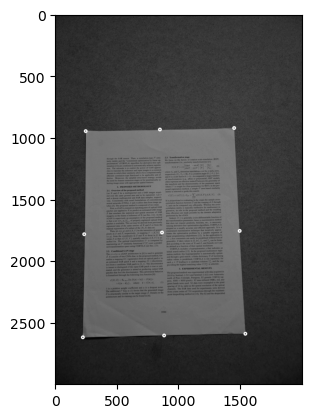

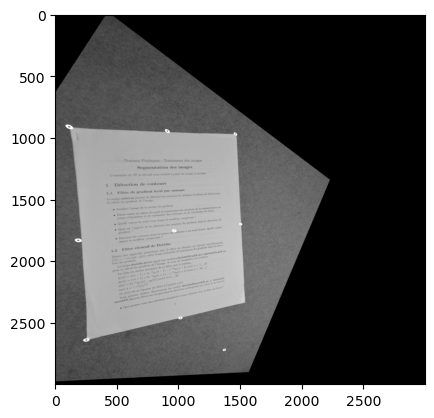

In [10]:
pts1 = [
    [248, 949],
    [1450, 924],
    [1541, 2592],
    [225, 2621],
]

pts1.append(np.mean(pts1, axis=0, dtype=int).tolist())
pts1.append(np.mean([pts1[0], pts1[1]], axis=0, dtype=int).tolist())
pts1.append(np.mean([pts1[0], pts1[3]], axis=0, dtype=int).tolist())
pts1.append(np.mean([pts1[1], pts1[2]], axis=0, dtype=int).tolist())
pts1.append(np.mean([pts1[2], pts1[3]], axis=0, dtype=int).tolist())

pts2 = [
    [2030, 110],
    [2750, 904],
    [920, 1638],
    [363, 663],
]

pts2.append(np.mean(pts2, axis=0, dtype=int).tolist())
pts2.append(np.mean([pts2[0], pts2[1]], axis=0, dtype=int).tolist())
pts2.append(np.mean([pts2[0], pts2[3]], axis=0, dtype=int).tolist())
pts2.append(np.mean([pts2[1], pts2[2]], axis=0, dtype=int).tolist())
pts2.append(np.mean([pts2[2], pts2[3]], axis=0, dtype=int).tolist())

pts2[2] = [300, 1638]

img1_plot = img1.copy()
for i in range(len(pts1)):
    img1c_dec = cv2.circle(img1_plot, pts1[i], radius=10, color=(255, 0, 0), thickness=10)
plt.figure(), plt.imshow(img1c_dec, cmap="gray")

img2_plot = img2.copy()
for i in range(len(pts2)):
    img2c_dec = cv2.circle(img2_plot, pts2[i], radius=10, color=(255, 0, 0), thickness=10)
plt.figure(), plt.imshow(img2c_dec, cmap="gray")

# In all the following, we will use the convention that np.shape(pts1) = [2xnumber_of_points]
pts1 = np.array(pts1).T
# In all the following, we will use the convention that np.shape(pts1) = [2xnumber_of_points]
pts2 = np.array(pts2).T

H = compute_homography(pts1, pts2)
homography_matrix_normalized = H / H[2, 2]
result = cv2.warpPerspective(
    img2_plot, np.linalg.inv(homography_matrix_normalized), (3000, 3000)
)
plt.imshow(result, cmap="gray")
plt.show()

# Part 2: automatic homography estimation and panorama stitching

To bypass the flaws that we observed with the previous method, we now propose to use a robust homography estimation method, the RANSAC algorithm. As an application, we will consider panorama stitching: from two given overlapping images, create a single one which is a panorama. To do that, we will need to estimate the best homography to warp an image into the perspective of the other. In addition, to avoid the cumbersome choice of the matching points between the two images, we will do an automatic keypoint identification by using the SIFT features.

Let us first load the two considered images.

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x154f083bdd0>)

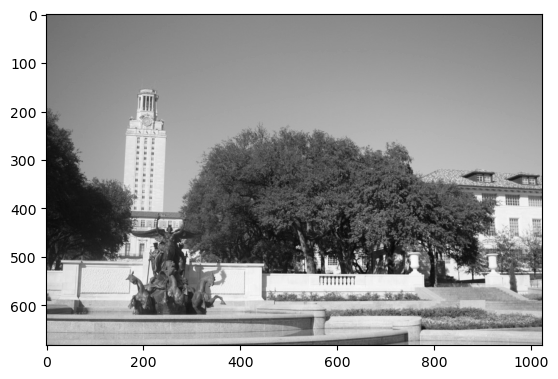

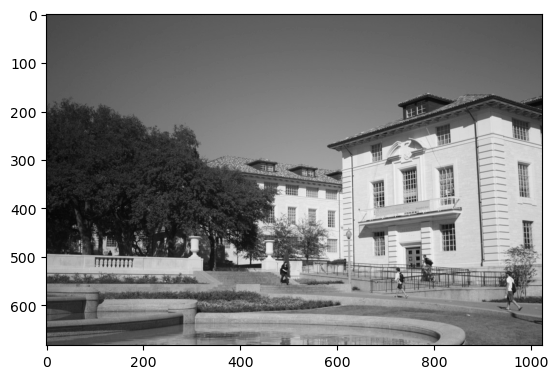

In [11]:
img1c = cv2.cvtColor(cv2.imread("uttower_left.jpg"), cv2.COLOR_BGR2GRAY)
img2c = cv2.cvtColor(cv2.imread("uttower_right.jpg"), cv2.COLOR_BGR2GRAY)

img1 = img1c
img2 = img2c

plt.figure(), plt.imshow(img1, cmap="gray")
plt.figure(), plt.imshow(img2, cmap="gray")

To stitch the two images, we need to have access to pair of corresponding points between image 1 and image 2. To do that, we first need to extract some keypoints in both images (that will be matched later on). We will use here the SIFT descriptors.

**Implement** the SIFT descriptors for both image 1 and image 2. You might be willing to use the `cv2.SIFT_create` and `sift.detectAndCompute`.

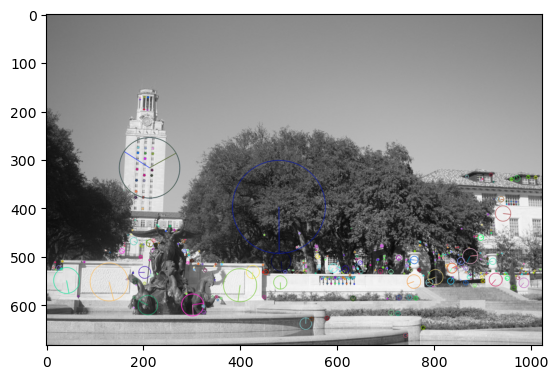

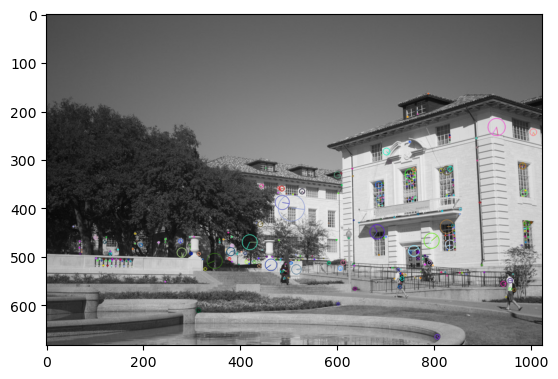

In [12]:
# Creates an object of the SIFT class. The larger the threshold, the smaller the number of points
sift = cv2.SIFT_create(
    contrastThreshold=0.15,
    edgeThreshold=10,
)

# kp1 = location of the keypoints, desc1 = corresponding descriptors.
kp1, desc1 = sift.detectAndCompute(img1, None)


# For visualization
img1c = cv2.drawKeypoints(
    img1, kp1, img1c, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)

plt.imshow(img1c)
plt.show()

# kp2 = location of the keypoints, desc2 = corresponding descriptors.
kp2, desc2 = sift.detectAndCompute(img2, None)

# For visualization
img2c = cv2.drawKeypoints(

    img2, kp2, img2c, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)


plt.imshow(img2c)
plt.show()

**Question:** explain the shapes of desc1, kp1 and desc2, kp2 and their respective roles.

**Answer:**

- Keypoints (`kp1` and `kp2`): The shape of `kp1` and `kp2` would be `(N, )`, where `N` is the number of keypoints detected in each image. They serve as anchor points around which descriptors are computed. Each keypoint has associated coordinates, scale, orientation, and possibly other attributes depending on the feature detection algorithm used.

- Descriptors (`desc1` and `desc2`): The shape of `desc1` and `desc2` would be `(N, M)`, where `N` is the number of keypoints and `M` is the dimensionality of each descriptor vector. Descriptors encode the visual information surrounding each keypoint into a numerical vector. They capture the local structure and appearance of the image patch centered at each keypoint. Descriptors are designed to be robust to changes in viewpoint, scale, and lighting conditions.

Now that we have obtained the SIFT descriptor, we have to match them.

**Complete** the following code.

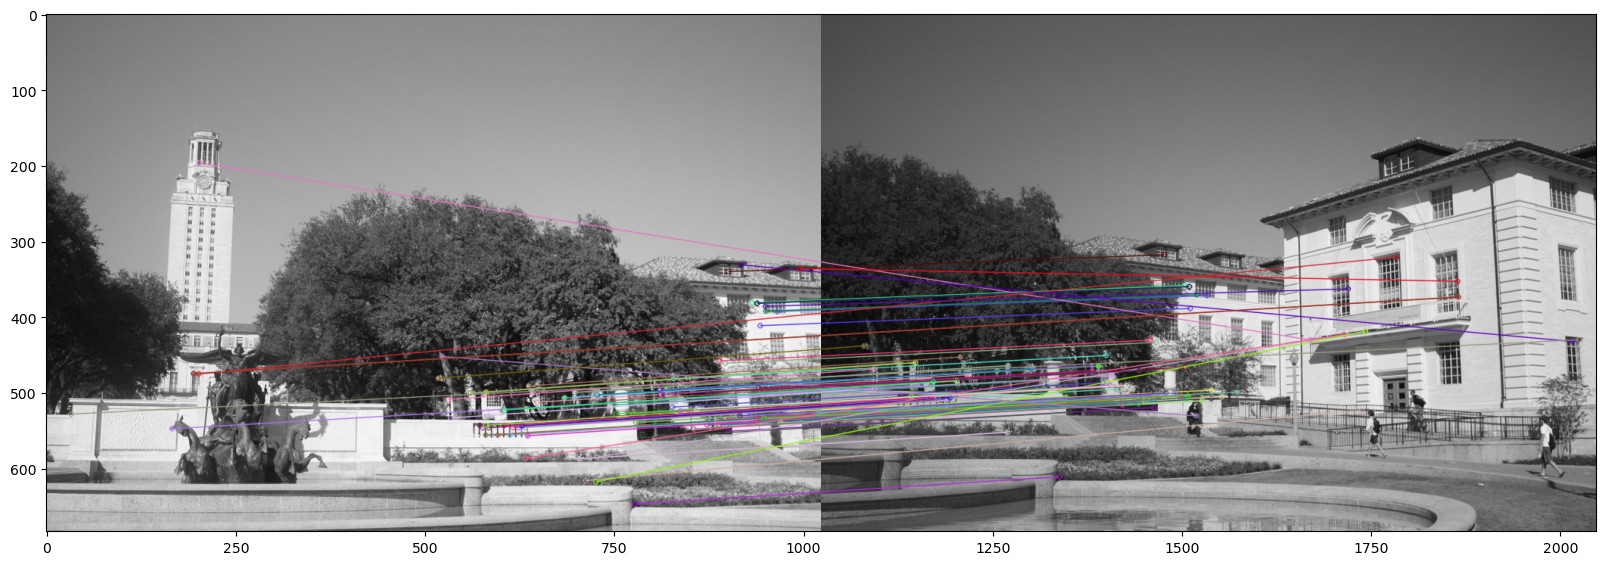

In [13]:
# feature matching
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

matches = bf.match(desc1, desc2)

matches = sorted(matches, key=lambda x: x.distance)


# For visualizing the matches
img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches[:100], img2, flags=2)
plt.figure(figsize=(20, 12)), plt.imshow(img3)
plt.show()

**Question:** comment the match quality. Do you think that the previous matching would enable a decent homography computation using the DLT algorithm of the first part?

**Answer:**

The process of feature matching, while attempting to establish correspondences between keypoints in different images, can be prone to errors and inaccuracies. In many cases, despite some of the found matches corresponding to actual correspondences between the images, a significant portion of the matches may be erroneous or inaccurate. This can be due to various factors such as occlusions, changes in lighting conditions, or similarities between different regions of the images.

As a result, as the matches obtained from feature matching does not appear to be sufficiently accurate, the homography computation using DLT would suffer. The DLT algorithm, in particular, is known to be sensitive to noise and inaccuracies in the input data. Even a small number of incorrect correspondences can lead to significant errors in the estimated homography matrix, ultimately affecting the quality of the stitched or transformed images.

The following code enables to keep only the coordinates of the 100 best matches in the two images. We will use them as an input of a RANSAC, which will enable to do a robust homography estimation between the two images.

In [14]:
D1 = np.ones((2, 100))  # Coordinates in image 1 of the first best matching points
D2 = np.ones((2, 100))  # Coordinates in image 2 of the first best matching points
for ii in range(100):
    D1[:, ii] = kp1[matches[ii].queryIdx].pt
    D2[:, ii] = kp2[matches[ii].trainIdx].pt

D1 = D1.astype(int)
D2 = D2.astype(int)

In [15]:
print(D1.shape)

(2, 100)


Now, we are ready to code the RANSAC algorithm.

**Fill** the gaps in the code below.

In [16]:
def ransac(D1, D2, num, threshold, iterations):
    # D1, D2 : matched points between the two images
    # num : number of points to compute the homography
    # threshold : distance threshold for determining if a pair of point in an inlier or an outlier
    # iterations : number of iterations / number of sampling

    # D1h correspond to D1 transformed into homogeneous coordinates
    D1h = np.vstack((D1, np.ones((1, D1.shape[1]))))

    # D2h correspond to D2 transformed into homogeneous coordinates
    D2h = np.vstack((D2, np.ones((1, D2.shape[1]))))

    # Number of points in D1
    n = D1.shape[1]

    best_n_inlier = 0
    # Best homography matrix. Fill the gap with a matrix of the right size full of 0.
    best_H = np.zeros((3, 3))

    for i in range(iterations):
        # Draw randomly 4 indices to extract 4 points among D1 and D2. You can use np.random.choice()
        s = np.random.choice(n, num, replace=False)

        pts1 = D1[:, s]  # pts1 is the chosen points among D1
        pts2 = D2[:, s]  # pts2 is the chosen points among D2

        # Compute the corresponding homography. You can reuse the function of part I.
        H = compute_homography(pts1, pts2)

        # Transform the points of D1h to be able to compare them to the ones of D2h
        D2_new = H @ D1h

        # Normalize D2_new
        D2_new[0, :] = np.divide(D2_new[0, :], D2_new[2, :])
        D2_new[1, :] = np.divide(D2_new[1, :], D2_new[2, :])
        D2_new[2, :] = np.divide(D2_new[2, :], D2_new[2, :])

        # Compute the distance between D2_new and D2h
        SD = np.linalg.norm(D2h - D2_new, ord=2, axis=0)

        # Compute the inliers
        inliers = np.where(SD < threshold)[0]
        # Compute the number of inliers
        num_inlier = len(inliers)

        # If you obtained the best result, store the corresponding homography
        if num_inlier > best_n_inlier:
            best_H = H
            best_n_inlier = num_inlier
            point1 = D1[:2, inliers]
            point2 = D2[:2, inliers]
            in_res = SD[inliers]

    return best_H, best_n_inlier, point1, point2, in_res

Using the function you implemented above, **launch the RANSAC algorithm** to estimate the homography between the two images.

In [17]:
threshold = 1
num = 4
iterations = 1000
[H, inliers, point1, point2, residue] = ransac(D1, D2, num, threshold, iterations)

Normalizing data using similarity matrix...
Normalizing data using similarity matrix...

Stacked matrix A shape: (8, 9)

Reshaping to get homography H_tilde...

Denormalized to obtain homography H for 2D data points...
Matrix H:
[[ 6.48047315e-01  2.89299541e-01 -4.51421427e+02]
 [ 1.07259690e-01  1.18320585e+00 -3.93341451e+02]
 [ 1.87061325e-04  1.20730845e-03 -1.47124519e-01]]
Normalizing data using similarity matrix...
Normalizing data using similarity matrix...

Stacked matrix A shape: (8, 9)

Reshaping to get homography H_tilde...

Denormalized to obtain homography H for 2D data points...
Matrix H:
[[ 5.54695970e-01 -7.64057856e-01  1.94708311e+02]
 [-2.03371603e-01 -3.47839888e-01  6.83361103e+02]
 [-4.31616919e-04 -2.13928016e-03  2.15740336e+00]]
Normalizing data using similarity matrix...
Normalizing data using similarity matrix...

Stacked matrix A shape: (8, 9)

Reshaping to get homography H_tilde...

Denormalized to obtain homography H for 2D data points...
Matrix H:
[[-6.

C:\Users\willf\AppData\Local\Temp\ipykernel_21568\583383254.py:34: RuntimeWarning: divide by zero encountered in divide
  D2_new[0, :] = np.divide(D2_new[0, :], D2_new[2, :])
C:\Users\willf\AppData\Local\Temp\ipykernel_21568\583383254.py:35: RuntimeWarning: invalid value encountered in divide
  D2_new[1, :] = np.divide(D2_new[1, :], D2_new[2, :])
C:\Users\willf\AppData\Local\Temp\ipykernel_21568\583383254.py:36: RuntimeWarning: invalid value encountered in divide
  D2_new[2, :] = np.divide(D2_new[2, :], D2_new[2, :])



Reshaping to get homography H_tilde...

Denormalized to obtain homography H for 2D data points...
Matrix H:
[[-6.49898855e-01 -2.18131885e-01  4.47626823e+02]
 [-5.43928394e-01 -1.35799243e+00  8.67992750e+02]
 [-1.17069827e-03 -1.98114090e-03  1.39484982e+00]]
Normalizing data using similarity matrix...
Normalizing data using similarity matrix...

Stacked matrix A shape: (8, 9)

Reshaping to get homography H_tilde...

Denormalized to obtain homography H for 2D data points...
Matrix H:
[[ 6.02041270e-01 -1.57407060e-01 -2.14473365e+02]
 [ 2.13420213e-01  4.69114554e-01 -1.59234866e+02]
 [ 3.80501301e-04 -1.99493576e-04  3.23195855e-01]]
Normalizing data using similarity matrix...
Normalizing data using similarity matrix...

Stacked matrix A shape: (8, 9)

Reshaping to get homography H_tilde...

Denormalized to obtain homography H for 2D data points...
Matrix H:
[[ 6.59224516e-01 -5.46232624e-02 -2.81256035e+02]
 [ 8.21461180e-02  6.12879568e-01 -7.64504310e+01]
 [ 1.25214924e-04 -4.14

In [18]:
print(H)

[[ 4.31704219e-01 -3.18764131e-02 -1.87350896e+02]
 [ 5.89068489e-02  3.97825387e-01 -5.48090196e+01]
 [ 9.97731254e-05 -7.41272661e-06  3.32747267e-01]]


Lastly, **fill the code** below to warp img2 into the same space as img1

In [19]:
result = cv2.warpPerspective(
    img2, np.linalg.inv(H / H[2, 2]), (img1.shape[1] + img2.shape[1], img1.shape[0])
)
result[0 : img1.shape[0], 0 : img1.shape[1]] = img1

**Question:** Plot the panorama image. How good is it? Any comment?

**Answer**:

The results seem acceptable, as the homography was successfully calculated, despite the initial noise.

RANSAC's robustness to outliers, iterative refinement, threshold-based outlier rejection, and random sampling strategy enable it to perform well in scenarios where DLT may fail due to the presence of outliers or inaccuracies in the input data. By effectively handling outliers and iteratively refining the model, RANSAC can produce more accurate and reliable estimations of geometric transformations such as homographies.

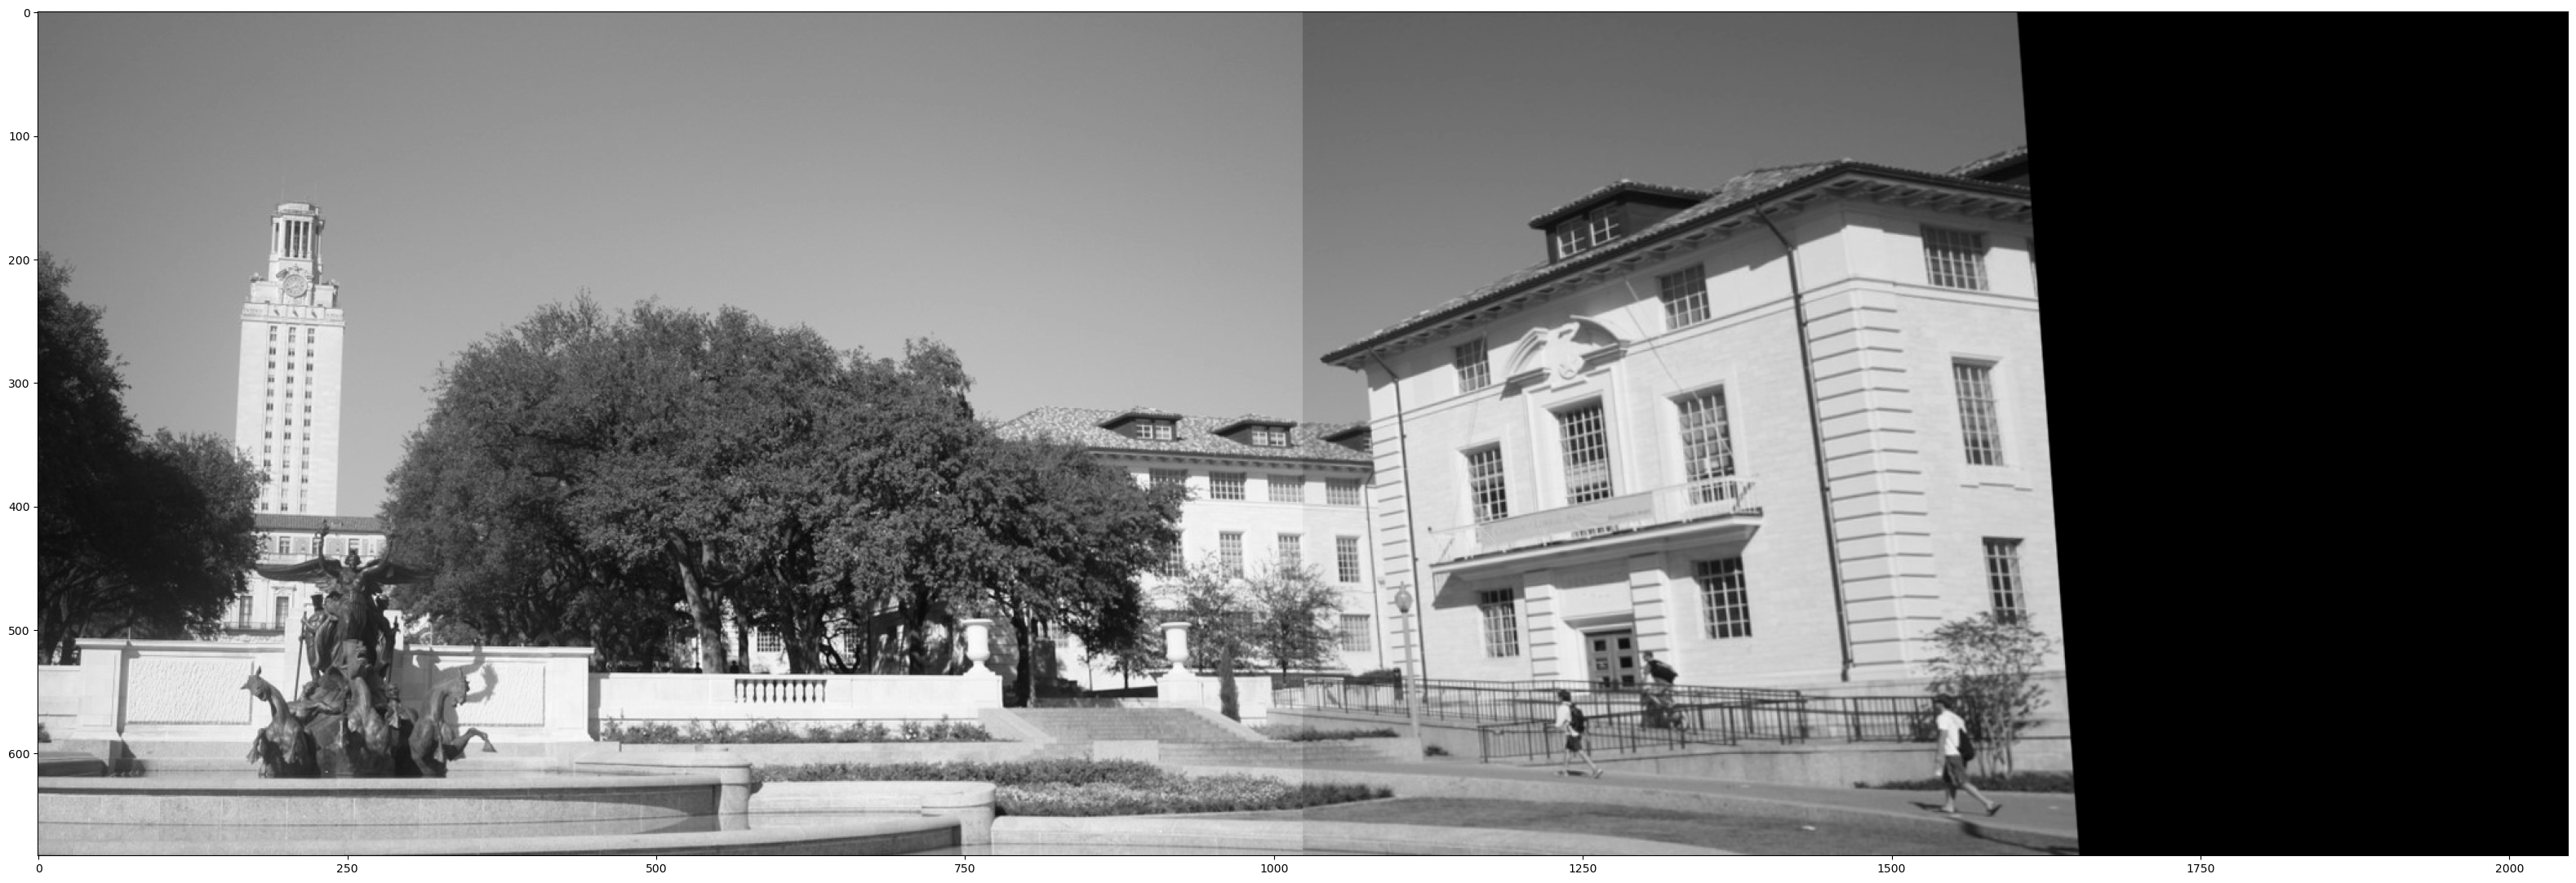

In [20]:
plt.figure(figsize=(40, 20)), plt.imshow(result, cmap="gray")
plt.show()

**Bonus**: try other descriptors than the SIFT ones. Try to implement your own.

**Bonus:** try to correct the change of luminosity between the two images so that the panorama look more realistic.